In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nhanes-senior-classification/Train_Data.csv
/kaggle/input/nhanes-senior-classification/Test_Data.csv


# **Nutrition Health Survey- Age Prediction**
## **1. Objective**
This notebook tackles the binary classification task of predicting whether a person is a **Senior (65+ years)** or not, using health and nutrition data from a curated subset of the NHANES survey.

Dataset Source: CDC's National Health and Nutrition Examination Survey (NHANES)  

Task: Predict the `age_group` as:
- `0` → Adult (Age < 65)
- `1` → Senior (Age ≥ 65)

## **2. Load Data & Libraries**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Load files
train = pd.read_csv('/kaggle/input/nhanes-senior-classification/Train_Data.csv')   
test = pd.read_csv('/kaggle/input/nhanes-senior-classification/Test_Data.csv')

## **3. Exploratory Data Analysis**

age_group    1.000000
LBXGLT       0.249944
LBXGLU       0.128616
PAQ605       0.092762
DIQ010       0.023626
SEQN         0.022023
RIAGENDR     0.000270
BMXBMI      -0.011797
LBXIN       -0.065271
Name: age_group, dtype: float64


<Axes: title={'center': 'Target Class Distribution'}, xlabel='age_group', ylabel='BMXBMI'>

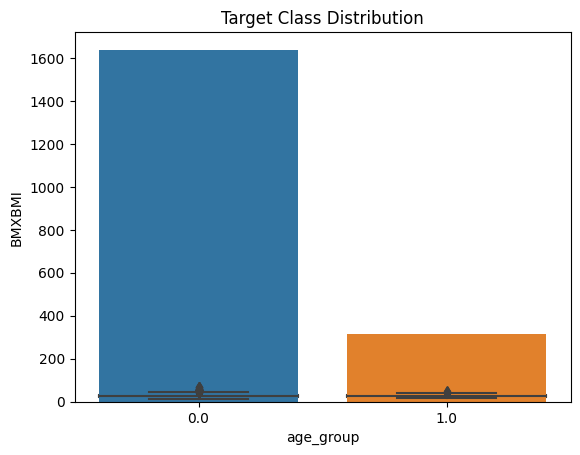

In [3]:
# Target distribution
sns.countplot(data=train, x='age_group')
plt.title('Target Class Distribution')

# Convert target to 0/1
train['age_group'] = train['age_group'].map({'Adult': 0, 'Senior': 1})

# Check missing values
train.isna().sum()

# Check correlation with target
correlations = train.corr(numeric_only=True)['age_group'].sort_values(ascending=False)
print(correlations)

# Optional: Visuals like histograms, boxplots
sns.boxplot(data=train, x='age_group', y='BMXBMI')

## **4. Preprocessing**

In [4]:
print(train.columns)
print(test.columns)

# Imputation
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(train.drop('age_group', axis=1))
y_train = train['age_group']
X_test = imputer.transform(test)

# (Optional) Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Index(['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT',
       'LBXIN', 'age_group'],
      dtype='object')
Index(['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT',
       'LBXIN'],
      dtype='object')


## **5. Modelling and Evaluation**

In [5]:
# Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)

# Simple baseline: Logistic Regression
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train, y_train)
print("Logistic Regression Accuracy:", lr.score(X_train, y_train))

# Random Forest (usually performs well on tabular data)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluation on training set (or create a hold-out validation split)
preds_train = rf.predict(X_train)
print(confusion_matrix(y_train, preds_train))
print(classification_report(y_train, preds_train))

Logistic Regression Accuracy: 0.8336724313326551
[[1638    0    0]
 [   0  314    0]
 [   0    0   14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1638
           1       1.00      1.00      1.00       314
           2       1.00      1.00      1.00        14

    accuracy                           1.00      1966
   macro avg       1.00      1.00      1.00      1966
weighted avg       1.00      1.00      1.00      1966



## **6. Predict on Test Set**

In [6]:
test_preds = rf.predict(X_test)
submission = pd.DataFrame({'age_group': test_preds})
submission.to_csv('submission.csv', index=False)
submission.head()

,age_group
0,0
1,0
2,0
3,0
4,0


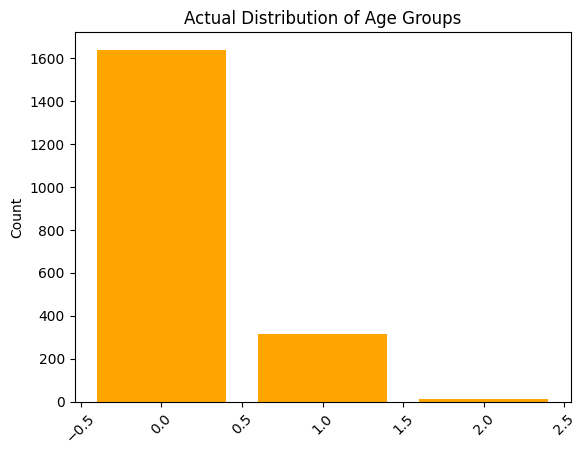

In [7]:
# Checking for the Distribution clearly
import matplotlib.pyplot as plt

labels, counts = np.unique(y_train, return_counts=True)
plt.bar(labels, counts, color='orange')
plt.title("Actual Distribution of Age Groups")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## **7. Conclusion**
- A Random Forest model was trained to classify individuals as "Adult" or "Senior" using health indicators.  
- Future improvements could include hyperparameter tuning, more advanced feature engineering, and ensembling multiple models.